# Tutorial 4: Inference

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
# Imports
import sys
sys.path.append('..')  # mamke nft_helpers module available

import matplotlib.pyplot as plt
import cv2 as cv
import large_image

# from nft_helpers import extract_tissue_mask
from nft_helpers.utils import imread
from nft_helpers.yolov5 import roi_inference, wsi_inference
from nft_helpers import extract_tissue_mask

In [3]:
help(roi_inference)

Help on function roi_inference in module nft_helpers.yolov5.roi_inference:

roi_inference(fp: str, weights: str, tile_size: int = 1280, stride: int = 960, temp_dir: str = '.temp', save_fp: str = None, yolodir: str = '/workspace/yolo', iou_thr: float = 0.4, contained_thr: float = 0.7, boundary_thr: float = 0.2, fill: Tuple[int] = (114, 114, 114), device: str = None, conf_thr: float = 0.4) -> geopandas.geodataframe.GeoDataFrame
    Run inference on an ROI with a YOLO model for prediction of NFTs.
    
    Args:
        fp: Filepath to ROI image. Should be in an /images/ directory and 
            have /labels/ and /boundaries/ text files of similar name.
        weights: Weights to use when predicting.
        tile_size: Size of image when tiling.
        stride: Stride when tiling, should be less than tile_size to overlap
            adjacent tiles.
        temp_dir: Tile images are saved temporarily and then deleted.
        save_fp: Save resutls to a text file.
        yolodir: Locati

In [9]:
# Parameters
# ----------
# Choose weights to load on YOLO model to predict. The best.pt file in the repo is the best MAL weights from
# project.
weights = '/workspace/code/best.pt'

# Select an ROI image to test. Note that some ROIs have no NFTs to predict so might return no predictions.
roi_fp = '/workspace/data/images/6381484f7f8a5e686a5c1915-x47201y68544.png'

# We provide a sample WSI for testing inference but others will work too.
wsi_fp = '/workspace/data/E21-110_TAU_1.svs'

# For WSI we speed tiling by using parallel processing in Python 
# This parameter sets the number of processes to use, don't set this higher than the number
# cores your machine otherwise it will be detrimental.
nproc = 10

device = None  # options, "cpu", None (all GPUs available), or specific ids (e.g. "0,1")

# Thresholds:
iou_thr = 0.4  # non-max-suppresion IoU
contained_thr = 0.7  # removing small boxes mostly in larger ones
conf_thr = 0.5  # remove predictions of low confidence
mask_thr = 0.25  # ignore tiles that are mostly not in ROI or tissue mask

## Part 1: ROI Inference

In [7]:
# You can save ROI labels as a text file in the YOLO format by passing save_fp parameter.
save_fp = '/workspace/data/sample-roi-label.txt'

pred_df = roi_inference(
    roi_fp, weights, save_fp=save_fp, device=device, 
    iou_thr=iou_thr, contained_thr=contained_thr, conf_thr=conf_thr, 
    boundary_thr=mask_thr
)
pred_df.head()

detect: weights=['/workspace/code/best.pt'], source=/workspace/code/tutorials/.temp/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.4, max_det=1000, device=0,1, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=True, classes=None, agnostic_nms=True, augment=False, visualize=False, update=False, project=/workspace/code/tutorials/.temp, name=predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-8-3 Python-3.8.13 torch-1.13.0a0+d0d6b1f CUDA:0 (NVIDIA TITAN V, 12057MiB)
                                                        CUDA:1 (NVIDIA TITAN V, 12057MiB)

Fusing layers... 
Model summary: 276 layers, 35254692 parameters, 0 gradients, 48.9 GFLOPs
image 1/64 /workspace/code/tutorials/.temp/images/6381484f7f8a5e686a5c1915-x47201y68544-x0y1920.png: 1280x1280 1 Pre-NFT, 5 iNFTs, 24.0ms
image 2/64 /workspace/code/tutorials/.temp/images/6381484f7f8a5e686a5c1915-x47

,label,x1,y1,x2,y2,conf,geometry
209,1,4227,1456,4315,1542,0.923771,"POLYGON ((4227.000 1456.000, 4315.000 1456.000..."
278,1,4802,3752,4906,3835,0.923072,"POLYGON ((4802.000 3752.000, 4906.000 3752.000..."
376,1,7347,1125,7448,1229,0.922598,"POLYGON ((7347.000 1125.000, 7448.000 1125.000..."
474,1,8774,5489,8874,5587,0.919743,"POLYGON ((8774.000 5489.000, 8874.000 5489.000..."
135,1,3105,5869,3194,5963,0.919362,"POLYGON ((3105.000 5869.000, 3194.000 5869.000..."


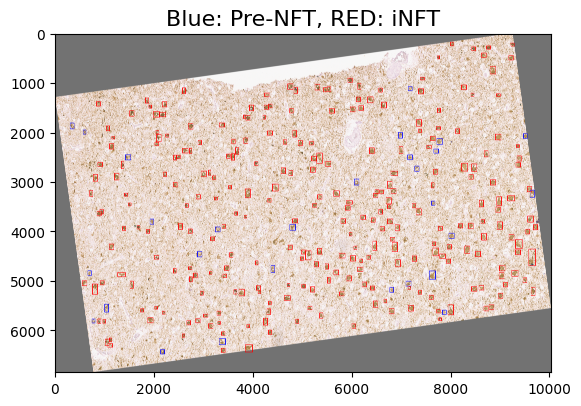

In [8]:
# Visualize
roi_img = imread(roi_fp)

# Draw predictions on image.
for _, r in pred_df.iterrows():
    roi_img = cv.rectangle(
        roi_img,
        (r.x1, r.y1), 
        (r.x2, r.y2), 
        (255, 0, 0) if r.label else (0, 0, 255),
        10
    )

plt.imshow(roi_img)
plt.title("Blue: Pre-NFT, RED: iNFT", fontsize=16)
plt.show()

## Part 2: WSI Inference

In [16]:
help(wsi_inference)

Help on function wsi_inference in module nft_helpers.yolov5.wsi_inference:

wsi_inference(fp, gc=None, weights='yolov5m6.pt', mask=None, doc_name='default', wsi_id=None, exist_ok=True, stride=960, tile_size=1280, nproc=10, rgb_fill=(114, 114, 114), device=None, conf_thr=0.5, nms_iou_thr=0.6, contained_thr=0.8, save_fp=None, colors=None, labels=None, mask_thr=0.25)
    Predict objects on an entire WSI using YOLOv5 model and an inference workflow.
    
    INPUTS
    ------
    fp : str
        file path to the WSI file
    gc : girderClient
        authenticated girder client, needed push results as annotations
    weights : str
        file path to .pt file with yolov5 weights
    mask : str or array-like
        binary mask to specify regions of WSI to inference on. Either pass the array directly or a file path to the mask file. The mask can be (and should be) at a smaller
        scale then the WSI but should be of the same aspect ratio. If aspect ratio is not the same the results wi

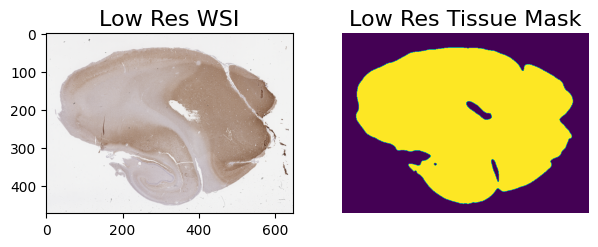

In [38]:
# Step 1: Create binary mask of tissue
# This speeds up the workflow since we will ignore a lot of pixels that have not tissue.
lr_mag = 0.25  # magnification to extract tissue mask at
sigma = 5  # smooths the tissue extraction, higher values will remove holes but might not be a good thing

img, mask, ts = extract_tissue_mask(wsi_fp, lr_mag=lr_mag, sigma=sigma)

# Visualize
fig = plt.figure(figsize=(7,4))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Low Res WSI', fontsize=16)
fig.add_subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Low Res Tissue Mask', fontsize=16)
plt.axis('off')
plt.show()

In [17]:
# Step 2: WSI inference.
tile_df, pred_df, logs = wsi_inference(
    wsi_fp, weights=weights, mask=mask, nproc=nproc, device=device, nms_iou_thr=iou_thr,
    contained_thr=contained_thr, conf_thr=conf_thr
)

saving temporary tile images...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4625/4625 [04:21<00:00, 17.66it/s]


predicting tile labels...


detect: weights=['/workspace/code/best.pt'], source=/workspace/code/tutorials/.temp/E21-110_TAU_1/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.4, max_det=1000, device=0,1, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=True, classes=None, agnostic_nms=True, augment=False, visualize=False, update=False, project=/workspace/code/tutorials/.temp, name=E21-110_TAU_1, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-8-3 Python-3.8.13 torch-1.13.0a0+d0d6b1f CUDA:0 (NVIDIA TITAN V, 12057MiB)
                                                        CUDA:1 (NVIDIA TITAN V, 12057MiB)

Fusing layers... 
Model summary: 276 layers, 35254692 parameters, 0 gradients, 48.9 GFLOPs
image 1/4625 /workspace/code/tutorials/.temp/E21-110_TAU_1/images/E21-110_TAU_1_x1-10560_y1-16320_x2-11840_y2-17600.png: 1280x1280 (no detections), 23.9ms
image 2/4625 /workspace/code/tutorials/.temp/

merging predictions...


2575 NFT predictions.


,fp,label,x1,y1,x2,y2,conf,box_area
0,/workspace/code/tutorials/.temp/E21-110_TAU_1/...,1.0,67664.99904,30264.00000,67826.99968,30571.00032,0.525876,49734.24832
1,/workspace/code/tutorials/.temp/E21-110_TAU_1/...,1.0,27160.00000,12122.99968,27364.99968,12338.00000,0.591374,44074.99680
2,/workspace/code/tutorials/.temp/E21-110_TAU_1/...,1.0,90007.00032,22754.00064,90311.00032,22895.00032,0.608579,42863.90272
3,/workspace/code/tutorials/.temp/E21-110_TAU_1/...,1.0,51707.00032,29287.00032,51862.00064,29560.99968,0.608541,42469.98848
4,/workspace/code/tutorials/.temp/E21-110_TAU_1/...,1.0,52590.00000,51670.00064,52758.99968,51899.00032,0.626839,38700.87264


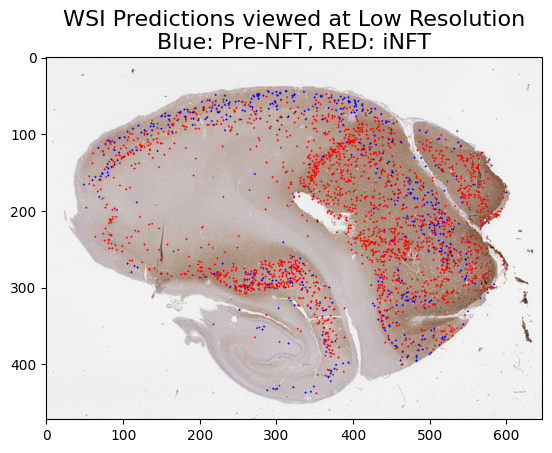

In [45]:
# Visualize by plotting predictions as dots.
print(f'{len(pred_df)} NFT predictions.')
display(pred_df.head())

# Get convertion factor from WSI resolution to our mask.
sf = img.shape[0] / ts['sizeY']

img_with_preds = img[:, :, :3].copy()

for _, r in pred_df.iterrows():
    # Calculate the center of box at low res.
    xc, yc = int((r.x1 + r.x2) / 2 * sf), int((r.y1 + r.y2) / 2 * sf)
    
    img_with_preds = cv.circle(
        img_with_preds, 
        (xc, yc), 
        1, 
        (255, 0, 0) if r.label else (0, 0, 255),
        cv.FILLED
    )
    
plt.imshow(img_with_preds)
plt.title("WSI Predictions viewed at Low Resolution\nBlue: Pre-NFT, RED: iNFT", fontsize=16)

plt.show()